<a href="https://colab.research.google.com/github/Pager07/TensorflowSpecialization/blob/master/C4W4_RNNTimeSeriesAndLamdaLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Creating windowed dataset 

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
window_size  + 1 

21

#RNN model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train,window_size,batch_size=128,
                             shuffle_buffer = shuffle_buffer_size)
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),
                                                           input_shape=[None]),#incomingshape:[Sample,Tx] now shape (sample,Tx,F)
                                    tf.keras.layers.SimpleRNN(40,return_sequences=True),
                                    tf.keras.layers.SimpleRNN(40),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,callbacks=[lr_schedule])

In [9]:
%debug

> <ipython-input-6-720f594d874c>(3)windowed_dataset()
      1 def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
      2   dataset = tf.data.Dataset.from_tensor_slices(series)
----> 3   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
      4   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
      5   dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))

ipdb> window_size
<function windowed_dataset at 0x7f1cb0258378>
ipdb> exit


(1e-08, 0.0001, 0.0, 30.0)

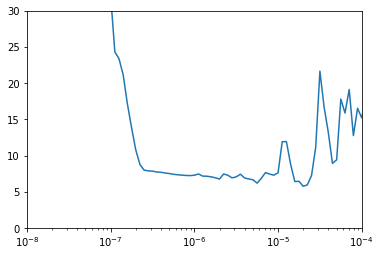

In [12]:
plt.semilogx(history.history["lr"], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

What is backend.clear_session()?
 - This helps reset the model.
 - this clears any internal variables. That makes it easy for us to experiment without models impacting later versions of themselves. 

In [ ]:
tf.keras.backend.clear_session() 
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train,window_size,batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1), input_shape=[None]),
                                    tf.keras.layers.SimpleRNN(40,return_sequences=True),
                                    tf.keras.layers.SimpleRNN(40),
                                    tf.keras.layers.Dense(1),
                                    tf.keras.layers.Lambda(lambda x:x *100.0),
])
optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer= optimizer,
              metrics=['mae'])
history = model.fit(dataset, epochs=400)

#Evaluating

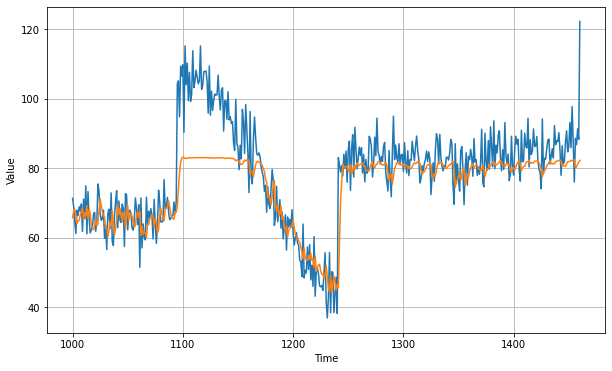

In [16]:
forecast = []
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size].reshape(1,-1)))

forecast = forecast[split_time-window_size:]
results = np.array(forecast).flatten()

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid,results).numpy()

6.710335

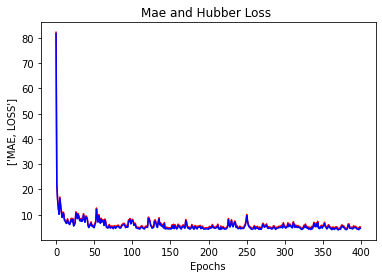

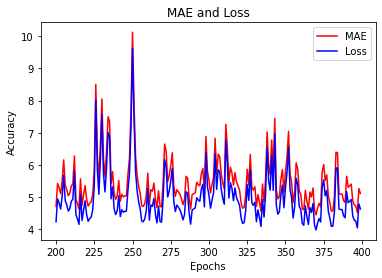

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs,mae,'r')
plt.plot(epochs,loss,'b')
plt.title('Mae and Hubber Loss ')
plt.xlabel('Epochs')
plt.ylabel(['MAE, LOSS'])

plt.figure()
epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

